In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import seaborn

In [2]:
uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

def stripTagsAndUris(x):
    if x:
        # BeautifulSoup on content
        soup = BeautifulSoup(x, "html.parser")
        # Stripping all <code> tags with their content if any
        if soup.code:
            soup.code.decompose()
        # Get all the text out of the html
        text =  soup.get_text()
        # Returning text stripping out all uris
        return re.sub(uri_re, "", text)
    else:
        return ""

def removePunctuation(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    x = re.sub(r'[^\x00-\x7f]',r' ',x)
    # Removing (replacing with empty spaces actually) all the punctuations
    return re.sub("["+string.punctuation+"]", " ", x)

In [3]:
def normalize_df(filename):
    columns = ["country","sku_id","title","category_lvl_1","category_lvl_2","category_lvl_3","short_description",
           "price","product_type"]
    dat = pd.read_csv(filename,names=columns)
    dat['short_desc_strip'] = dat.short_description.fillna("").map(stripTagsAndUris)
    return dat.drop(['sku_id','short_description'],axis=1)

In [4]:
columns = ["country","sku_id","title","category_lvl_1","category_lvl_2","category_lvl_3","short_description",
           "price","product_type"]
dat = pd.read_csv("data/training/data_train.csv",names=columns)
clarity_lbl = pd.read_csv("data/training/clarity_train.labels",names=["label"])
concise_lbl = pd.read_csv("data/training/conciseness_train.labels",names=["label"])
dat_clarity = dat.copy(deep=True)

In [5]:
dat['short_desc_strip'] = dat.short_description.fillna("").map(stripTagsAndUris)

/usr/lib/python2.7/dist-packages/bs4/__init__.py:198: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  '"%s" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.' % markup)


In [6]:
dat_norm = dat.drop(['sku_id','short_description'],axis=1)

In [7]:
dat_norm['clarity'] = clarity_lbl['label']
dat_norm['concise'] = concise_lbl['label']

In [16]:
dat_norm[dat_norm.clarity==0]['short_desc_strip'].iloc[10]

u' Protective sleeve texture : Tpu Style : Protective shell Style : Europe and the united states Application of mobile phone models : Apple/apple Brand : Cute cloth  '

# Statistical

In [8]:
print "Number of claritiness = %s"%len(dat_norm[dat_norm['clarity']==0])

Number of claritiness = 2055


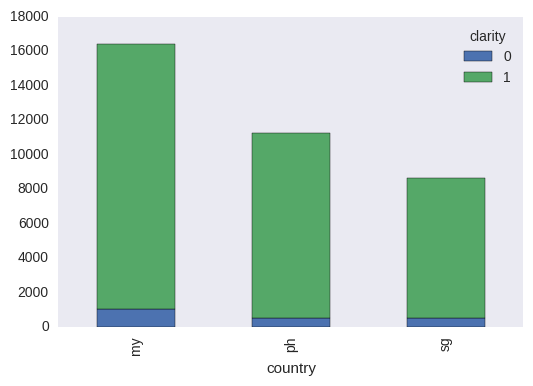

In [28]:
country_clarity = dat_norm.groupby(['country','clarity'])['country'].count()
%matplotlib inline
country_clarity.unstack(level=1,fill_value=0).plot(kind='bar',stacked=True,grid=False,rot=90)

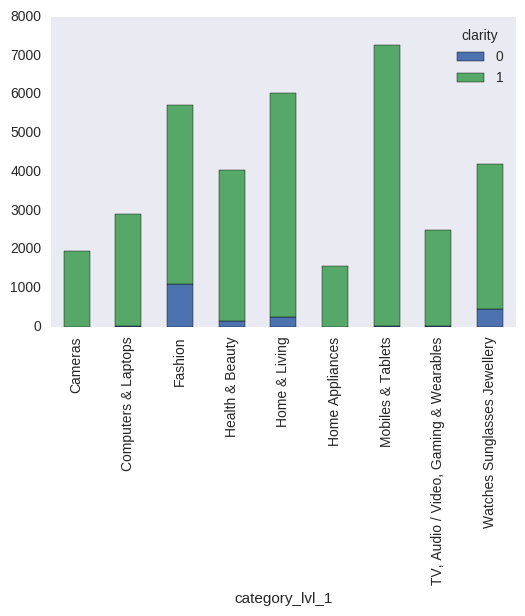

In [30]:
cat1_clarity = dat_norm.groupby(['category_lvl_1','clarity'])['country'].count()
%matplotlib inline
cat1_clarity.unstack(level=1,fill_value=0).plot(kind='bar',stacked=True,grid=False,rot=90)

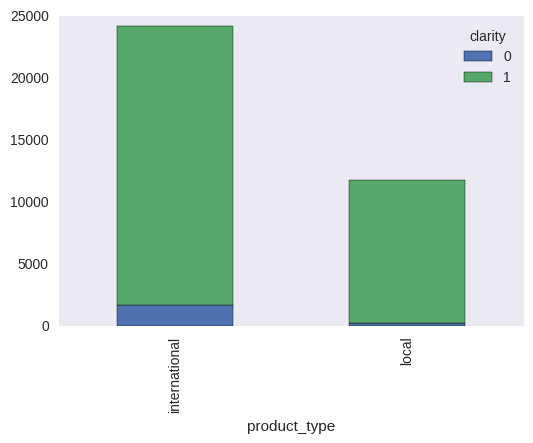

In [31]:
product_type_clarity = dat_norm.groupby(['product_type','clarity'])['country'].count()
%matplotlib inline
product_type_clarity.unstack(level=1,fill_value=0).plot(kind='bar',stacked=True,grid=False,rot=90)

In [32]:
dat_norm_desc_clarity = dat_norm[['short_desc_strip','clarity','title']]

In [36]:
dat_norm_desc_clarity['len_desc'] = dat_norm_desc_clarity['short_desc_strip'].map(len)
dat_norm_desc_clarity['len_title'] = dat_norm_desc_clarity['title'].map(len)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [41]:
df_len_desc = dat_norm_desc_clarity['len_desc']

# %matplotlib
labels = ['Low','Medium','High']
dat_norm_desc_clarity['len_desc_bin'] = pd.qcut(df_len_desc.values,[0,.5, .95, 1.],labels=labels)

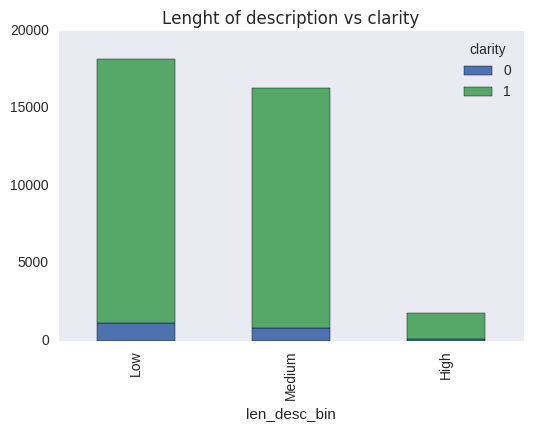

In [62]:
%matplotlib inline
len_desc_bin_type_clarity = dat_norm_desc_clarity.groupby(['len_desc_bin','clarity'])['len_desc_bin'].count()
len_desc_bin_type_clarity.unstack(level=1,fill_value=0).plot(kind='bar',stacked=True,grid=False,
            rot=90,title="Lenght of description vs clarity")

In [65]:
dat_norm_country_category = dat_norm[['country','category_lvl_1']]

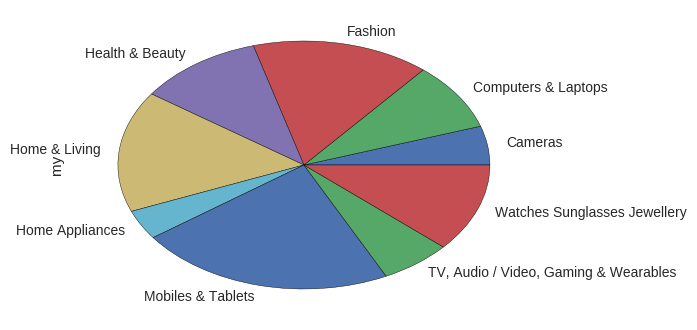

In [89]:
country_category_df = dat_norm_country_category.groupby(['country','category_lvl_1'])['country'].count()
# country_category_df.unstack(level=0,fill_value=0).plot(kind='pie',grid=False,subplots=True,figsize=(6,4),
#             rot=90,title="Category of product in country")
country_category_df.unstack(level=0,fill_value=0)['my'].plot(kind='pie')
# country_category_df.unstack(level=0,fill_value=0)['sg'].plot(kind='pie')

In [94]:
dat_norm.to_csv("data/training/dat_norm_with_labels.csv",index=None,encoding='utf8')